## Dimensionality reduction
- https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction
- http://scikit-learn.org/stable/modules/unsupervised_reduction.html
- http://scikit-learn.org/stable/modules/manifold.html#manifold

### PCA
- choose n_vars for which 95%-99% covariance of the data is explained
- you can pipeline a pca step to a logistic regression fit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

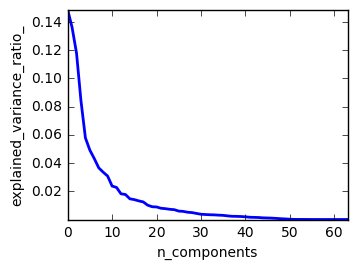

In [2]:
pca.fit(X_digits)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()

### Feature agglomeration
- applies Hierarchical clustering to group together features that behave similarly
- Note that if features have very different scaling or statistical properties, cluster.FeatureAgglomeration may not be able to capture the links between related features. Using a preprocessing.StandardScaler can be useful in these settings

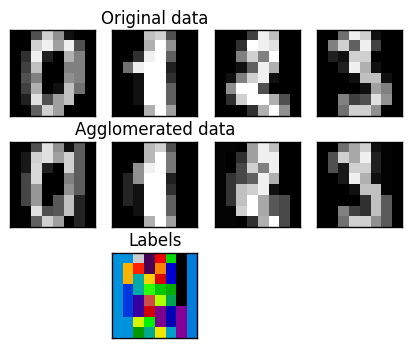

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, cluster
from sklearn.feature_extraction.image import grid_to_graph

digits = datasets.load_digits()
images = digits.images
X = np.reshape(images, (len(images), -1))
connectivity = grid_to_graph(*images[0].shape)

agglo = cluster.FeatureAgglomeration(connectivity=connectivity, n_clusters=32)

agglo.fit(X)
X_reduced = agglo.transform(X)

X_restored = agglo.inverse_transform(X_reduced)
images_restored = np.reshape(X_restored, images.shape)
plt.figure(1, figsize=(4, 3.5))
plt.clf()
plt.subplots_adjust(left=.01, right=.99, bottom=.01, top=.91)
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    if i == 1:
        plt.title('Original data')
    plt.subplot(3, 4, 4 + i + 1)
    plt.imshow(images_restored[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    if i == 1:
        plt.title('Agglomerated data')
    plt.xticks(())
    plt.yticks(())

plt.subplot(3, 4, 10)
plt.imshow(np.reshape(agglo.labels_, images[0].shape), interpolation='nearest', cmap=plt.cm.spectral)
plt.xticks(())
plt.yticks(())
plt.title('Labels')
plt.show()

### Random projections
- The dimensions and distribution of random projections matrices are controlled so as to preserve the pairwise distances between any two samples of the dataset
- Thus random projection is a suitable approximation technique for distance based method.
- The Gaussian random projection reduces the dimensionality by projecting the original input space on a randomly generated matrix where components are drawn from the following distribution N(0,1/n_componentes)
- The Sparse random projection reduces the dimensionality by projecting the original input space using a sparse random matrix that guarantees similar embedding quality while being much more memory efficient and allowing faster computation of the projected data. 
- If we define s = 1 / density => with probability 1/(2s) the random elemens are +-sqrt(s/n_components) and 0 with 1-1/s probability
- The simplest way to accomplish this dimensionality reduction is by taking a random projection of the data. In a random projection, it is likely that the more interesting structure within the data will be lost.

In [9]:
import numpy as np
from sklearn import random_projection
X = np.random.rand(100, 10000)
transformer = random_projection.GaussianRandomProjection()
X_new = transformer.fit_transform(X)
X_new.shape

(100, 3947)

In [10]:
import numpy as np
from sklearn import random_projection
X = np.random.rand(100,10000)
transformer = random_projection.SparseRandomProjection()
X_new = transformer.fit_transform(X)
X_new.shape

(100, 3947)

###  Independent Component Analysis

### Linear Discriminant Analysis

## Manifold learning (non linear data trasformation)
- Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task are based on the idea that the dimensionality of many data sets is only artificially high.
- Manifold Learning can be thought of as an attempt to generalize linear frameworks like PCA to be sensitive to non-linear structure in data
- Make sure the same scale is used over all features. Because manifold learning methods are based on a nearest-neighbor search, the algorithm may perform poorly otherwise. See StandardScaler for convenient ways of scaling heterogeneous data.
- NLDR has several applications in the field of computer-vision

The reconstruction error computed by each routine can be used to choose the optimal output dimension. For a d-dimensional manifold embedded in a D-dimensional parameter space, the reconstruction error will decrease as n_components is increased until n_components == d.
Note that noisy data can “short-circuit” the manifold, in essence acting as a bridge between parts of the manifold that would otherwise be well-separated. Manifold learning on noisy and/or incomplete data is an active area of research.
Certain input configurations can lead to singular weight matrices, for example when more than two points in the dataset are identical, or when the data is split into disjointed groups. In this case, solver='arpack' will fail to find the null space. The easiest way to address this is to use solver='dense' which will work on a singular matrix, though it may be very slow depending on the number of input points. Alternatively, one can attempt to understand the source of the singularity: if it is due to disjoint sets, increasing n_neighbors may help. If it is due to identical points in the dataset, removing these points may help.


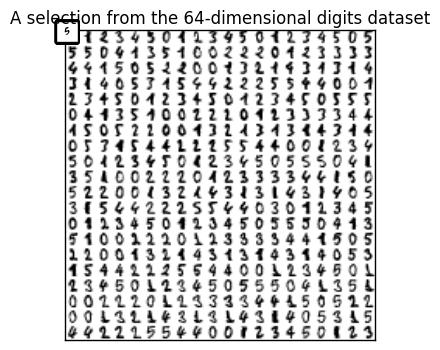

In [19]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]), color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()


#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

### Isomap
- seeks a lower-dimensional embedding which maintains geodesic distances between all points
- The Isomap algorithm comprises three stages: 1) Nearest neighbor search 2) Shortest-path graph search 3) Partial eigenvalue decomposition
- complexity grows approx as N^2-N^3

Computing Isomap embedding
Done.


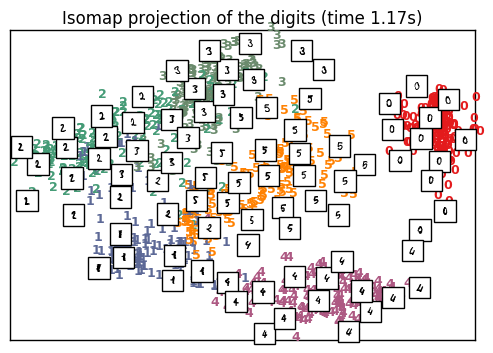

In [20]:
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso, "Isomap projection of the digits (time %.2fs)" % (time() - t0))

### Locally Linear Embedding
- seeks a lower-dimensional projection of the data which preserves distances within local neighborhoods
- It can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding
- three stages: 1) Nearest Neighbors Search (k-parameters to be choosen as also the distance metrics) 2) Weight Matrix Construction (It then computes a set of weights for each point that best describe the point as a linear combination of its neighbors) 3) Partial Eigenvalue Decomposition (The same weights Wij that reconstructs the ith data point in the D dimensional space will be used to reconstruct the same point in the lower d dimensional space, Each point Xi in the D dimensional space is mapped onto a point Yi in the d dimensional space by minimizing the cost function
$${\displaystyle C(Y)=\sum _{i}|{\mathbf {Y} _{i}-\sum _{j}{\mathbf {W} _{ij}\mathbf {Y} _{j}}|}^{\mathsf {2}}}$$
where i are all the samples and ij are the point nearest to the i point; the minimization of this cost function can be reconducted to a eigenvalue problem
- It has several advantages over Isomap, including faster optimization when implemented to take advantage of sparse matrix algorithms, and better results with many problems
- LLE tends to handle non-uniform sample densities poorly because there is no fixed unit to prevent the weights from drifting as various regions differ in sample densities

Computing LLE embedding
Done. Reconstruction error: 1.63544e-06


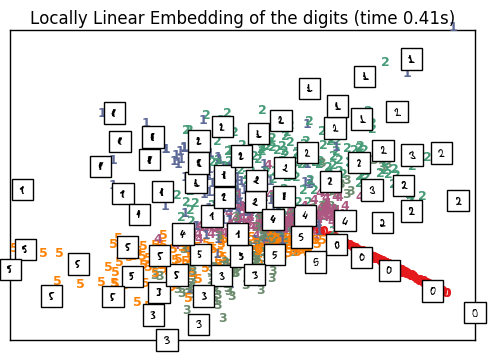

In [25]:
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle, "Locally Linear Embedding of the digits (time %.2fs)" % (time() - t0))

### Modified Locally Linear Embedding
- One well-known issue with LLE is the regularization problem. When the number of neighbors is greater than the number of input dimensions, the matrix defining each local neighborhood is rank-deficient. To address this, standard LLE applies an arbitrary regularization parameter r, which is chosen relative to the trace of the local weight matrix.
- MLLE produces robust projections similar to Hessian LLE, but without the significant additional computational cost
- One method to address the regularization problem is to use multiple weight vectors in each neighborhood. This is the essence of modified locally linear embedding (MLLE)
- in skit-learn uste the keyword method = 'modified'. It requires n_neighbors > n_components

Computing modified LLE embedding
Done. Reconstruction error: 0.360651


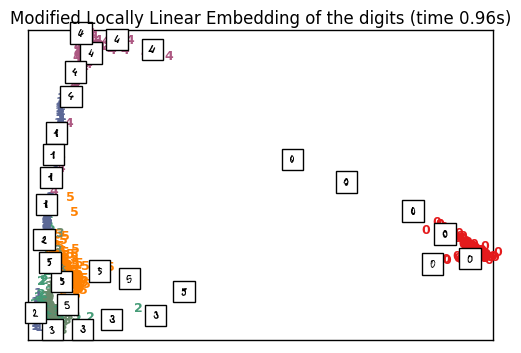

In [26]:
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle, "Modified Locally Linear Embedding of the digits (time %.2fs)" % (time() - t0))

### Hessian Eigenmapping or (Hessian Locally Linear Embedding)
-  It tends to yield results of a much higher quality than LLE. Unfortunately, it has a very costly computational complexity, so it is not well-suited for heavily-sampled manifolds
- is another method of solving the regularization problem of LLE. It revolves around a hessian-based quadratic form at each neighborhood
- The skit-learn implementation is fast and requires n_neighbors > n_components * (n_components + 3) / 2.

Computing Hessian LLE embedding
Done. Reconstruction error: 0.212806


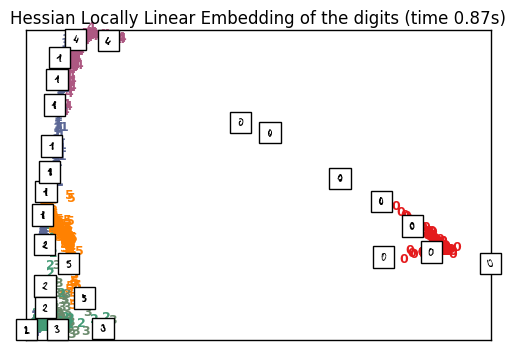

In [27]:
# HLLE embedding of the digits dataset
print("Computing Hessian LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_hlle, "Hessian Locally Linear Embedding of the digits (time %.2fs)" % (time() - t0))

### Spectral Embedding (aka Laplacian Eigenmaps)
- use a spectral decomposition of the graph Laplacian which is constructed from a simple graph G with n vertices as L = D - A, where D is the degree matrix (numbers of connections for each node, diagonal matrix) and A is the affinity matrix (ij is 1 if the i and j node are connected, it has zeros in the diagonal)
- Minimization of a cost function based on the graph ensures that points close to each other on the manifold are mapped close to each other in the low dimensional space, preserving local distances.
- comprises three stages: 1) Weighted Graph Construction 2) Graph Laplacian Construction 3) Partial Eigenvalue Decomposition (on graph Laplacian)

Computing Spectral embedding


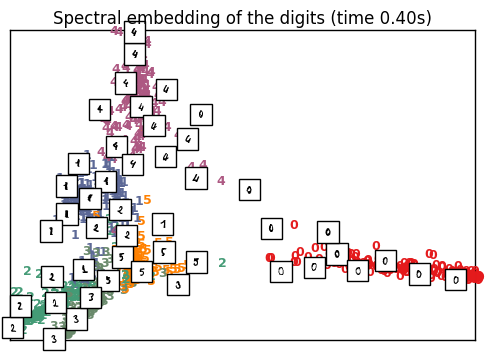

In [28]:
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0, eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se, "Spectral embedding of the digits (time %.2fs)" % (time() - t0))

### Local Tangent Space Alignment
- Rather than focusing on preserving neighborhood distances as in LLE, LTSA seeks to characterize the local geometry at each neighborhood via its tangent space, and performs a global optimization to align these local tangent spaces to learn the embedding.
- comprises three stages: 1) Nearest Neighbors Search 2) Weight Matrix Construction 3) Partial Eigenvalue Decompositio

Computing LTSA embedding
Done. Reconstruction error: 0.212803


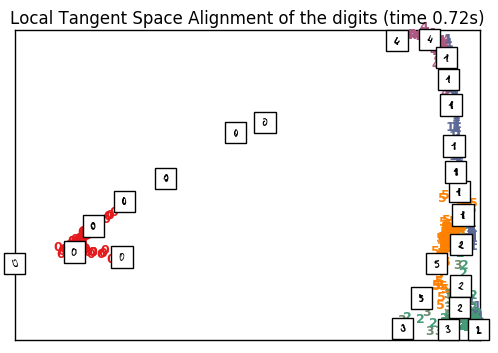

In [29]:
#----------------------------------------------------------------------
# LTSA embedding of the digits dataset
print("Computing LTSA embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_ltsa, "Local Tangent Space Alignment of the digits (time %.2fs)" % (time() - t0))


### Multi-dimensional Scaling (MDS)
- In general, is a technique used for analyzing similarity or dissimilarity data because it attempts to model similarity or dissimilarity data as distances in a geometric spaces
- There exists two types of MDS algorithm: metric and non metric.
- the distances between output two points are then set to be as close as possible to the similarity or dissimilarity data. In the non-metric version, the algorithms will try to preserve the order of the distances, and hence seek for a monotonic relationship between the distances in the embedded space and the similarities/dissimilarities.
- Note that the purpose of the MDS is to find a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space, unlike other manifold-learning algorithms, it does not seeks an isotropic representation of the data in the low-dimensional space.

Computing MDS embedding
Done. Stress: 160772902.076166


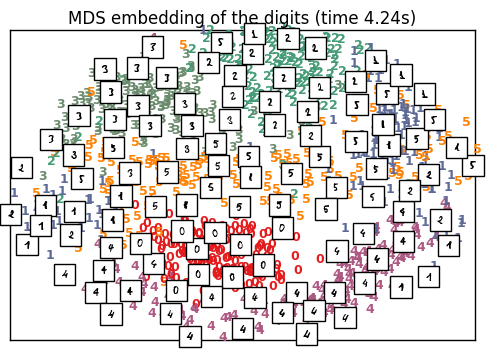

In [23]:
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds, "MDS embedding of the digits (time %.2fs)" % (time() - t0))

### t-distributed Stochastic Neighbor Embedding (t-SNE)
- converts affinities of data points to probabilities.
- The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions
- advantages over existing techniques: Revealing the structure at many scales on a single map; Revealing data that lie in multiple, different, manifolds or clusters; Reducing the tendency to crowd points together at the center
- The disadvantages: t-SNE is computationally expensive, and can take several hours on million-sample datasets where PCA will finish in seconds or minutes; The Barnes-Hut t-SNE method is limited to two or three dimensional embeddings.; Global structure is not explicitly preserved. This is problem is mitigated by initializing points with PCA (using init=’pca’).
- The main purpose of t-SNE is visualization of high-dimensional data. Hence, it works best when the data will be embedded on two or three dimensions.
- There are five parameters that control the optimization of t-SNE: perplexity (The perplexity is related to the number of nearest neighbors); early exaggeration factor (During early exaggeration the joint probabilities in the original space will be artificially increased by multiplication with a given factor. Larger factors result in larger gaps between natural clusters in the data. Usually it does not have to be tuned); learning rate (critical parameter, If it is too low gradient descent will get stuck in a bad local minimum. If it is too high the KL divergence will increase during optimization); maximum number of iterations (is usually high enough and does not need any tuning); angle (tradeoff between performance and accuracy. Larger angles imply that we can approximate larger regions by a single point,leading to better speed but less accurate results.)
- The optimization consists of two phases: the early exaggeration phase and the final optimization
- The Barnes-Hut t-SNE that has been implemented here is usually much slower than other manifold learning algorithms: 1) The Barnes-Hut implementation only works when the target dimensionality is 3 or less  2) Barnes-Hut only works with dense input data. Sparse data matrices can only be embedded with the exact method or can be approximated by a dense low rank projection for instance using sklearn.decomposition.TruncatedSVD  3) Barnes-Hut is significantly more scalable 4) Barnes-Hut is an approximation of the exact method. The approximation is parameterized with the angle parameter, therefore the angle parameter is unused when method=”exact”
- For visualization purpose (which is the main use case of t-SNE), using the Barnes-Hut method is strongly recommended

- This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the digits dataset.
- t-SNE has been used in a wide range of applications, including computer security research, music analysis, cancer research, bioinformatics, and biomedical signal processing

Computing t-SNE embedding


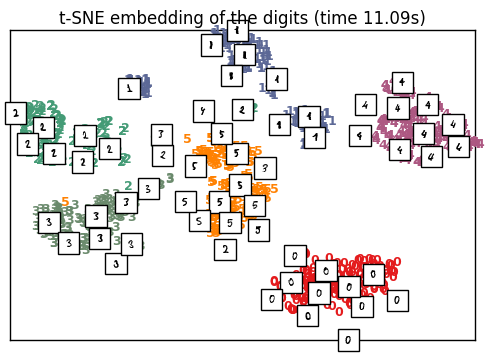

In [35]:
# t-SNE embedding of the digits dataset
# t-SNE will be initialized with the embedding that is generated by PCA in
# this example, which is not the default setting. It ensures global stability
# of the embedding, i.e., the embedding does not depend on random initialization.
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, "t-SNE embedding of the digits (time %.2fs)" % (time() - t0))

#### RandomTreesEmbedding
- The RandomTreesEmbedding, from the :mod:`sklearn.ensemble` module, is not
technically a manifold embedding method, as it learn a high-dimensional
representation on which we apply a dimensionality reduction method.
However, it is often useful to cast a dataset into a representation in
which the classes are linearly-separable.

Computing Totally Random Trees embedding


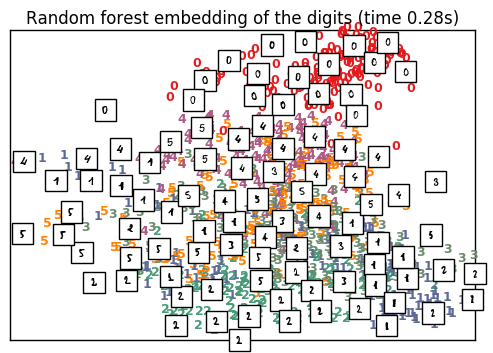

In [30]:
#----------------------------------------------------------------------
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0, max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced, "Random forest embedding of the digits (time %.2fs)" % (time() - t0))

### Comparison of Manifold Learning methods
- An illustration of dimensionality reduction on the S-curve dataset with various manifold learning methods.

standard: 0.12 sec
ltsa: 0.24 sec
hessian: 0.36 sec
modified: 0.25 sec
Isomap: 0.52 sec
MDS: 2.6 sec
SpectralEmbedding: 0.21 sec
t-SNE: 5.2 sec


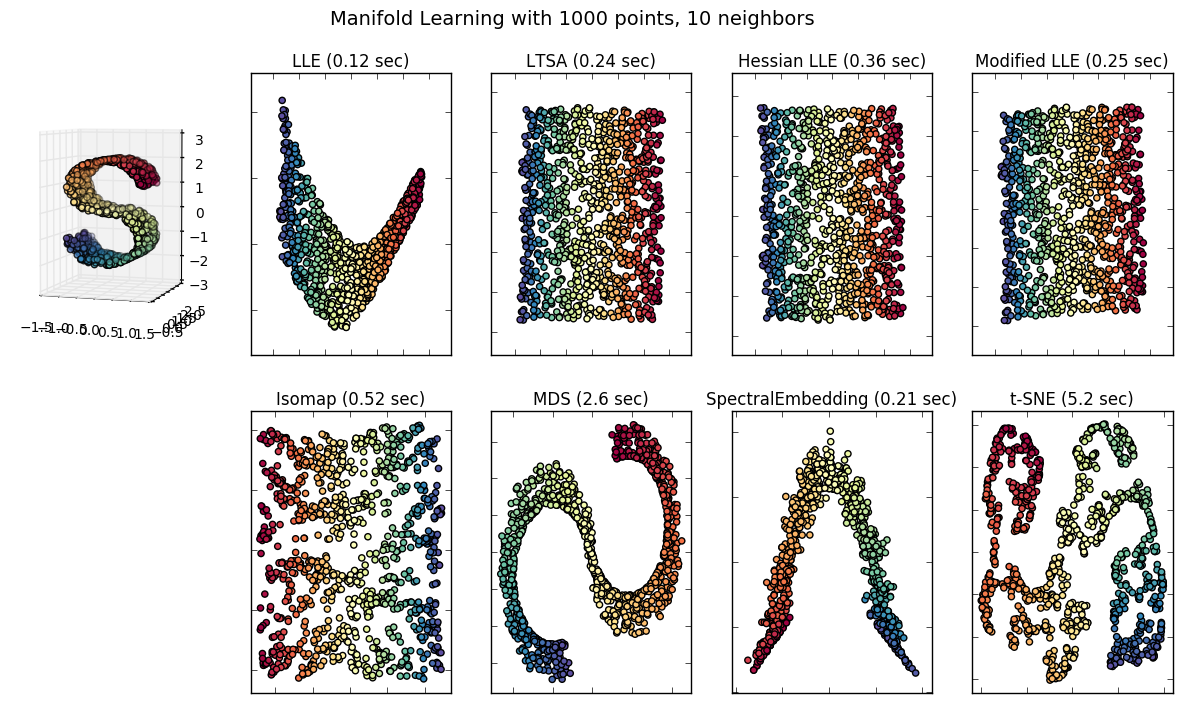

In [14]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors" % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(251, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(251, projection='3d')
    plt.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto', method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

### Other metods not supported in skit learn
https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction

### Kernel principal component analysis
-  KPCA begins by computing the covariance matrix of the data after being transformed into a higher-dimensional space
- It then projects the transformed data onto the first k eigenvectors of that matrix, just like PCA
-  it is not trivial to find a good kernel for a given problem, so KPCA does not yield good results with some problems when using standard kernels

### Autoencoders
- An autoencoder is a feed-forward neural network which is trained to approximate the identity function
- When used for dimensionality reduction purposes, one of the hidden layers in the network is limited to contain only a small number of network units. Thus, the network must learn to encode the vector into a small number of dimensions and then decode it back into the original space.

### Sammon's mapping
- Sammon's mapping is one of the first and most popular NLDR techniques.
- use a point representation in the embedded space to form a latent variable model based on a non-linear mapping from the embedded space to the high-dimensional space

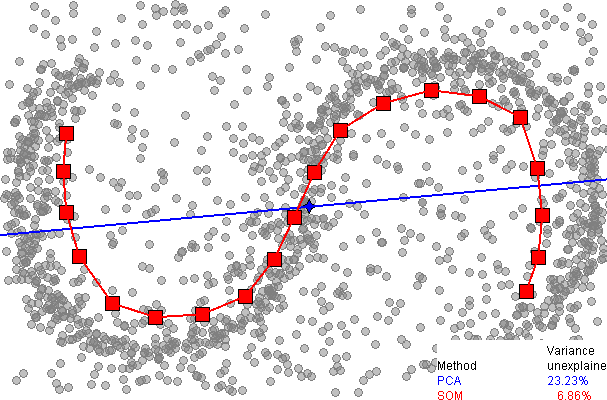

In [32]:
from IPython.display import Image, display; 
display(Image(filename='SOMsPCA.PNG'))